<a href="https://colab.research.google.com/github/border-b/QMLHEP/blob/main/QMLHEP_Test_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install qiskit-machine-learning
!pip install pylatexenc

Autoencoders are smaller neural networks that can achieve similar results as larger ones in deep learning. They offer the potential to accomplish tasks with fewer neurons in applications such as image classification, music composition, and art generation.

With a quantum autoencoder, we can take bigger state vectors and encode them into smaller ones. And the cool part is that this will drastically reduce the amount of resources needed to train the model.

In [58]:
import numpy as np
# Qiskit libraries 
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit import Parameter, ParameterVector

#MNIST set libraries for the acquisition and pre-processing data.
import tensorflow as tf

#Graph libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [59]:
#Loading the MNIST set divided by a train set and a test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

#Showing the length of the train and test sets
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

Number of images in the training set: 60000
Number of images in the test set: 10000


Due the constraint of resources available, we are only working with 0 and 1 digits in the MNIST dataset. This makes it a binary classification problem.

In [60]:
#Function to filter the 0 and 1 labels of the MNIST set
'''
Input = x_label and y_label sets
Output = x_label and y_label sets filtered
'''
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    return x,y

In [61]:
x_train, y_train = filter_01(x_train, y_train) #Filter the train set
x_test, y_test = filter_01(x_test, y_test) #Filter the test set

#Showing the length of the train and test sets after filtering the data
print("Number of images in the training set:", len(x_train))
print("Number of images in the test set:", len(x_test))

Number of images in the training set: 12665
Number of images in the test set: 2115


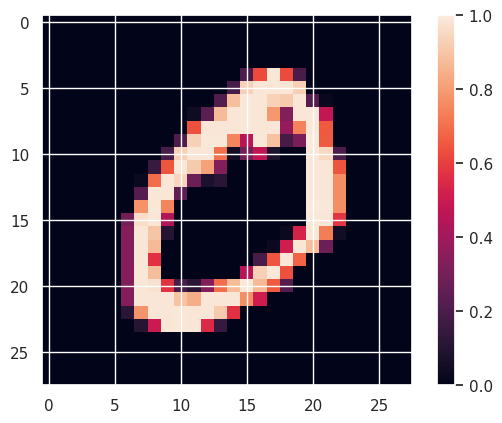

In [62]:
#Plotting the first element of the train set
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [63]:
#resizing the image from 28x28 to 8x8 by the nearest method
x_train_small = tf.image.resize(x_train, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_small = tf.image.resize(x_test, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

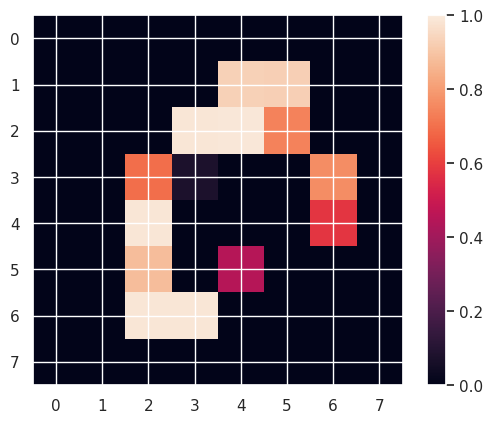

In [64]:
#Plotting the first element of the train set after the resizing
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [65]:
#Reshaping the train and test test to a 64x1 matriz
x_train = x_train_small.reshape(len(x_train_small), 64)
x_test = x_test_small.reshape(len(x_test_small), 64)
x_train.shape,x_test.shape

((12665, 64), (2115, 64))

In [66]:
#Showing the first element of the train set
x_train_small[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.93333333],
        [0.92941176],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.98823529],
        [0.99215686],
        [0.74117647],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.69803922],
        [0.0745098 ],
        [0.        ],
        [0.        ],
        [0.76470588],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.98823529],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.58039216],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.88235294],
        [0.        ],
        [0.44705882],


In [67]:
x_train = (x_train)
x_test = (x_test)

x_train.shape,x_test.shape

((12665, 64), (2115, 64))

In [68]:
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.93333333, 0.92941176, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.98823529,
       0.99215686, 0.74117647, 0.        , 0.        , 0.        ,
       0.        , 0.69803922, 0.0745098 , 0.        , 0.        ,
       0.76470588, 0.        , 0.        , 0.        , 0.98823529,
       0.        , 0.        , 0.        , 0.58039216, 0.        ,
       0.        , 0.        , 0.88235294, 0.        , 0.44705882,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.98823529, 0.98823529, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [69]:
#Deleting no valuable information for the training set
k = 0

while k < len(x_train):
    a = x_train[k].copy() #make a copy of the actual element
    #Verfify if it has some valuable data
    if np.sum(a) == 0.: 
        #If not has valuable data
        print(k,x_train[k]) 
        x_train = np.delete(x_train, k, axis=0) #Delete the actual element from the x_label
        y_train = np.delete(y_train, k, axis=0) #Delete the actual element from the y_label
        k -= 1 #Take back one value of the counter to match the new set length
    k+=1

In [70]:
#Deleting no valuable information for the test set
k = 0

while k < len(x_test): #Deleting no valuable information for the training set
    a = x_test[k].copy()
    #Verfify if it has some valuable data
    if np.sum(a) == 0.:
        #If not has valuable data
        print(k,x_test[k])
        x_test = np.delete(x_test, k, axis=0) #Delete the actual element from the x_label
        y_test = np.delete(y_test, k, axis=0) #Delete the actual element from the y_label
        k -= 1 #Take back one value of the counter to match the new set length
    k+=1

In [71]:
import cmath
#Funtion to normalize the data of an array
'''
Input = Array with n values
Output = Array with normalized valued
'''
def Normalize(row):
    #We calculate the squareroot of the sum of the square values of the row
    suma = np.sqrt(np.sum(row**2)) 
    if suma == 0.:
        #If the sum is zero we return a 0
        return 0.0
    #Else we divide each value between the sum value above
    row = row/suma
    return row 

#Normalize the training set data
for i in range(len(x_train)):
    x_train[i] = Normalize(x_train[i])

#Normalize the test set data
for i in range(len(x_test)):
    x_test[i] = Normalize(x_test[i])
    
#Showing the state sum of the training set    
print("The sum of the states from the training set 0",np.sum(x_train[0]**2))

The sum of the states from the training set 0 1.0


In [72]:
n=6 #Number of qubits 
num_layers = 1 #Number of layers
#Making a ndarray of floats based on the number of layers
params = np.random.random(10*(num_layers))

In [73]:
#Showing the normalized values of the first element of the training set
x_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.30173661, 0.30046881, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.31948582,
       0.32075362, 0.23961437, 0.        , 0.        , 0.        ,
       0.        , 0.22566856, 0.02408822, 0.        , 0.        ,
       0.24722117, 0.        , 0.        , 0.        , 0.31948582,
       0.        , 0.        , 0.        , 0.18763453, 0.        ,
       0.        , 0.        , 0.2852552 , 0.        , 0.1445293 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.31948582, 0.31948582, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

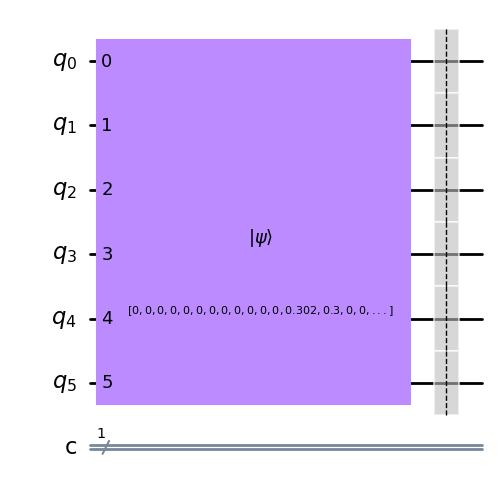

In [76]:
#Function to create a quantum circuit based on the number of qubit and a
#vector of complex amplitudes to initialize to
'''
Input: Number of qubits, vector of complex amplitudes
Output: Quantum Circuit
'''
def input_data(n,inputs):
    circuit = QuantumCircuit(n,1) #create the quantum circuit with n qubits
    #initialization of the circuit with the vector of amplitudes
    circuit.initialize(inputs,range(0,n,1)) 
    circuit.barrier() #Draw a barrier
    return circuit

#Example of a quantum circuit with the first row of te trainig set
input_data(n,x_train[0]).draw(output="mpl")

### Fidelity Check

The following function takes two quantum circuits and returns their fidelity.

In [74]:
# takes two circuts as input and returns their fidelity as output

def compute_fidelity(num_qubits, circuit1, circuit2):
    list1, list2 = [], []
    for i in range(num_qubits):
        list1.append(i + 1)
        list2.append(i + num_qubits + 1)
    swap_test_circuit = QuantumCircuit(2*num_qubits + 1, 1)

    swap_test_circuit.compose(circuit1, qubits=list1, inplace = True)
    swap_test_circuit.compose(circuit2, qubits=list2, inplace = True)
    swap_test_circuit.h(0)
    for i in range(num_qubits):
        swap_test_circuit.cswap(0,i+1,i+num_qubits+1)
    swap_test_circuit.h(0)
    swap_test_circuit.measure([0],[0])
    swap_test_circuit.draw('mpl')
    shots = 1024 #Number of shots
    #Execute the circuit in the qasm_simulator
    job = execute( swap_test_circuit, Aer.get_backend('qasm_simulator'),shots=shots )
    counts = job.result().get_counts() #Count the results of the execution
    if '1' in counts:
        m = counts['1']
    else:
        m = 0
    # print(1-2*m/shots)
    return (1 - 2*m/shots)

In [75]:
print(x_train[0].shape)
cc1 = input_data(n, x_train[0])
cc2 = input_data(n, x_train[1])

print(compute_fidelity(n, cc1, cc1))
print(compute_fidelity(n, cc1, cc2))

(64,)
1.0
-0.00390625


In [77]:
#Function to create a quantum variational circuit
'''
Input: number of qubits, number of layers, parameters to initialized the circuit
Output: Quantum Circuit
'''
def vqc(n, num_layers,params):
    #Set the number of layers and qubits
    #ParameterVectors are initialized with a string identifier and an integer specifying the vector length
    parameters = ParameterVector('θ', 10*(num_layers))
    len_p = len(parameters)
    circuit = QuantumCircuit(n, 1) #create the quantum circuit with n qubits
    

    #Creating the circuit for each layer
    for layer in range(num_layers):
        #Applying a ry gate in each qubit
        for i in range(n):
            #the rotation of the ry gate is defined in the parameters list
            #based on the layer
            circuit.ry(parameters[(layer)+i], i)
        circuit.barrier() #Create a barrier

        circuit.cx(2,0) #Apply a CNOT gate between the qubit 2 and 0
        circuit.cx(3,1) #Apply a CNOT gate between the qubit 3 and 1
        circuit.cx(5,4) #Apply a CNOT gate between the qubit 5 and 4
        circuit.barrier() #Create a barrier
        
        #Apply a RY gate in the qubit 0 with the rotation specified in the parameter list
        circuit.ry(parameters[6+(layer)],0)
        #Apply a RY gate in the qubit 1 with the rotation specified in the parameter list
        circuit.ry(parameters[7+(layer)],1)
        #Apply a RY gate in the qubit 4 with the rotation specified in the parameter list
        circuit.ry(parameters[8+(layer)],4)
        circuit.barrier() #Create a barrier
        
        circuit.cx(4,1) #Apply a CNOT gate between the qubit 4 and 1
        circuit.barrier() #Create a barrier
        
        #Apply a RY gate in the qubit 1 with the rotation specified in the parameter list
        circuit.ry(parameters[9+(layer)], 1)
        circuit.barrier() #Create a barrier
        

    #Creating a parameters dictionary
    params_dict = {}
    i = 0
    for p in parameters:
        #The name of the value will be the string identifier and an integer specifying the vector length
        params_dict[p] = params[i] 
        i += 1
    #Assign parameters using the assign_parameters method
    circuit = circuit.assign_parameters(parameters = params_dict)
    return circuit

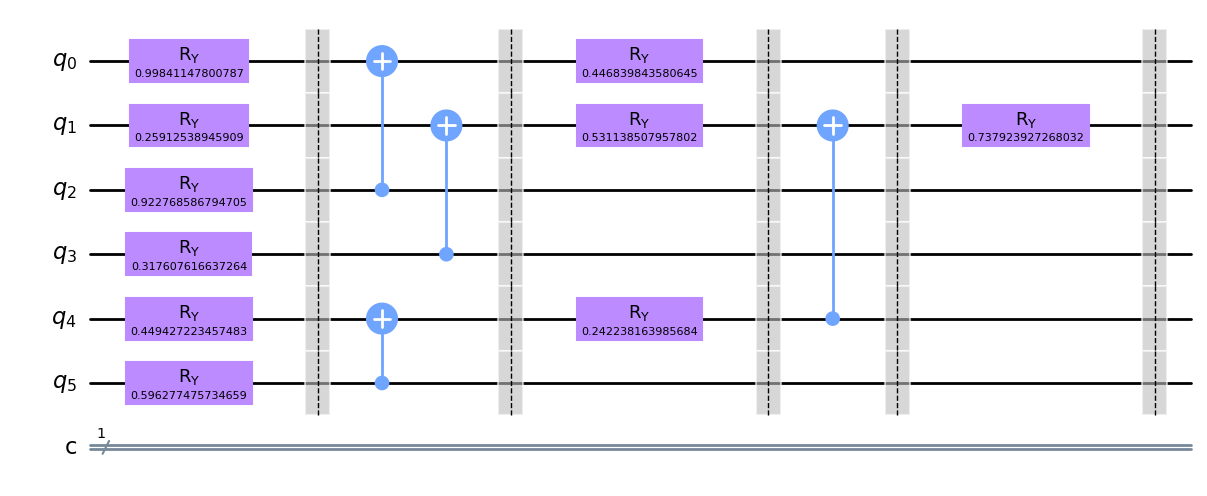

In [78]:
#An example with 6 quibits, one layer and 10 parameters
vqc(n,num_layers,params).draw(output="mpl")

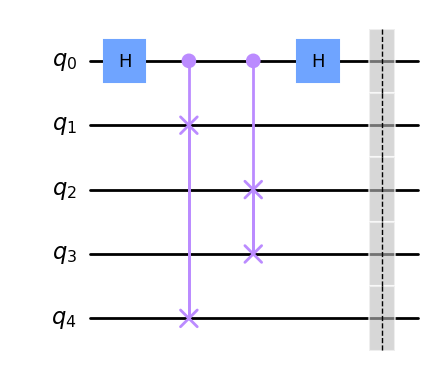

In [79]:
#Fucntion to make a swap test
'''
Input: Number of qubits
Output: Quantum circuit
'''
def swap_test(n):
    qubits_values = 2*n+1 #Create a new qubit value to create our circuit
    qc = QuantumCircuit(qubits_values) #Create the quantum circuit with the qubits value
    qc.h(0) #Applying a H gate to the first qubit
    for i in range(n):
        #Applying a cswap gate between the first quibit and the i+1 and 2*n-i qubits
        qc.cswap(0,i+1,2*n-i) 
    qc.h(0) #Applying a H gate to the first qubit
    qc.barrier() #Create a barrier
    return qc
#Example of a swap test with 2 quibits
swap_test(2).draw(output="mpl")

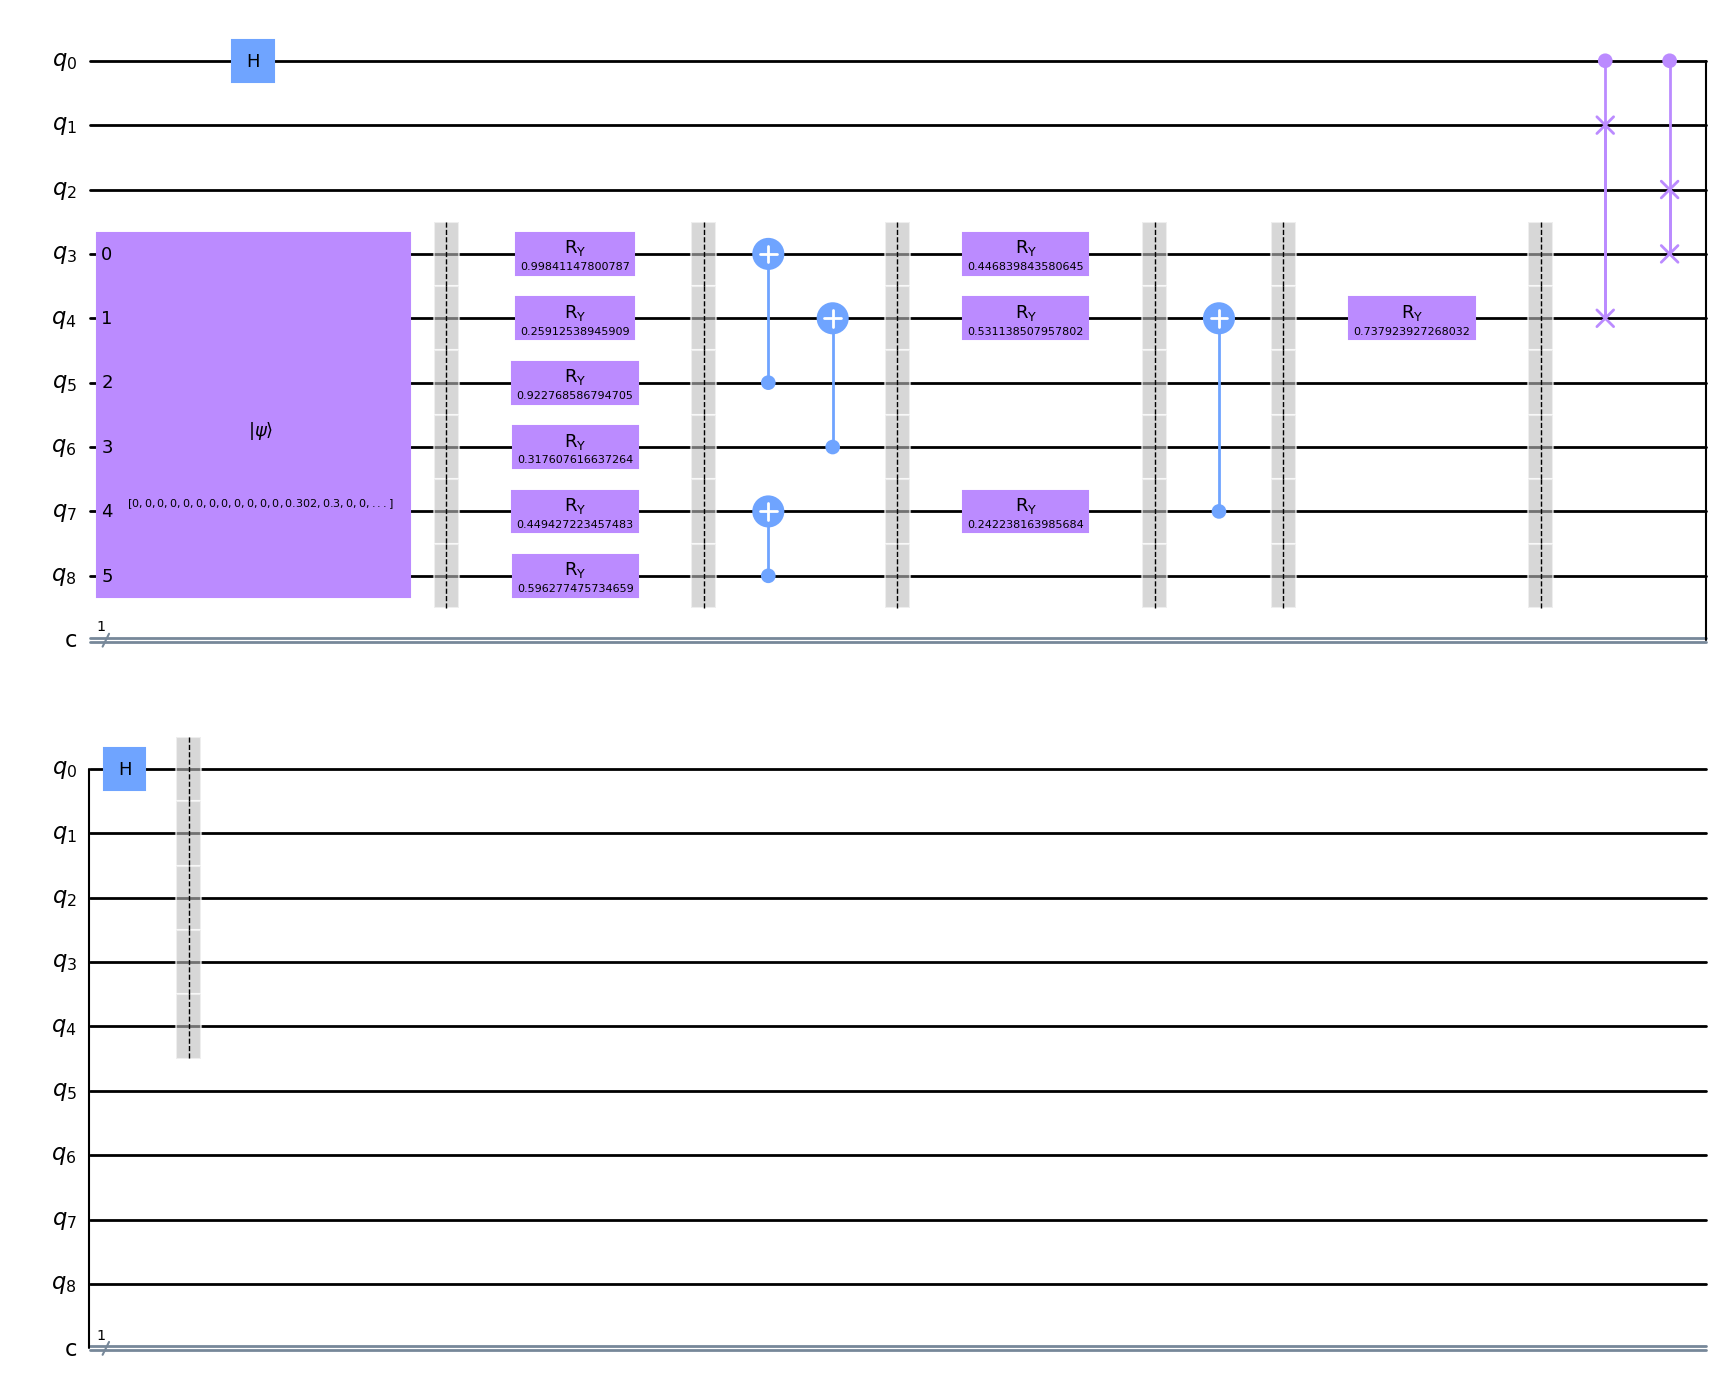

In [80]:
size_reduce = 2 #Number of qubits we want to reduce
circuit_init = input_data(n,x_train[0]) #Create a inicial circuit
circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit
circuit_swap_test = swap_test(size_reduce) #Create a swap test circuit

#Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
circuit_full = QuantumCircuit(n+size_reduce+1,1)

#Combine the initial circuit, the quantum variatinal circuit and the swap test
#For the initial circuit and QVC we start at the qubit size_reduce + 1
#For the swap test we start at the qubit 0
circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
circuit_full.draw(output="mpl")

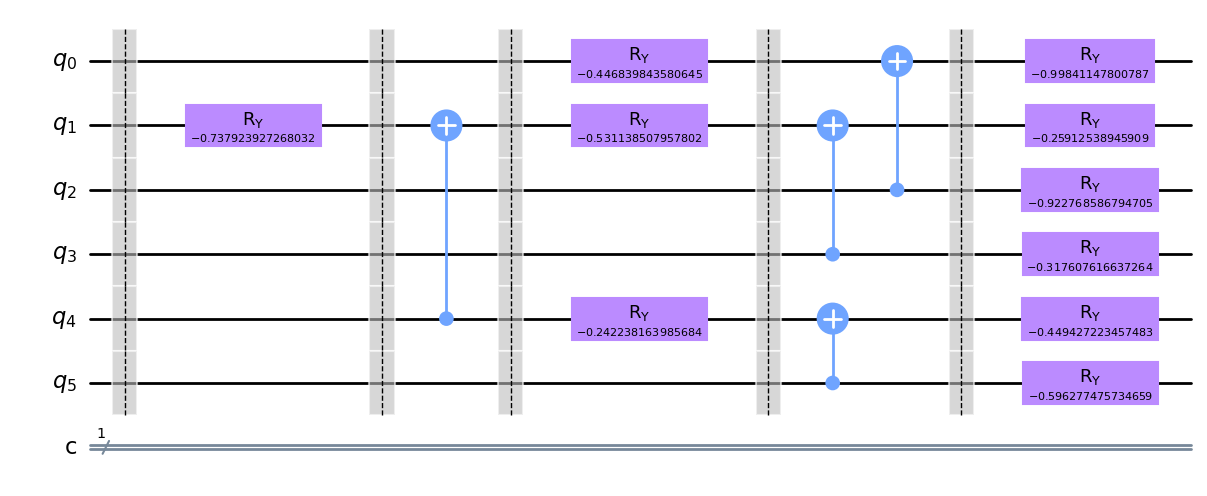

In [81]:
#We generate the inverse of the QVC
vqc(n,num_layers,params).inverse().draw(output = "mpl")

In [82]:
from random import shuffle
from scipy.optimize import minimize 

In [83]:
#Function to identify a function cost
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Function cost
'''
def objective_function(params):
    costo = 0
    shuffle(x_train) #reorganize the order of the train set items
    lenght= 5 #We only will consider the first five elements of the taining set
    #For each item of the trainig set
    for i in range(lenght):

        circuit_init = input_data(n,x_train[i])#Create a inicial circuit
        circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit
        circuit_swap_test = swap_test(size_reduce) #Create a swap test circuit

        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n+size_reduce+1,1)
        
        #Combine the initial circuit, the quantum variatinal circuit and the swap test
        #For the initial circuit and QVC we start at the qubit size_reduce + 1
        #For the swap test we start at the qubit 0
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(size_reduce+1,n+size_reduce+1)])
        circuit_full = circuit_full.compose(circuit_swap_test,[i for i in range(2*size_reduce+1)])
        circuit_full.measure(0, 0) #Measure the first qubit
        #qc.draw()
        shots= 1024 #Number of shots
        #Execute the circuit in the qasm_simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=shots )
        counts = job.result().get_counts() #Count the results of the execution
        probs = {} #Calculate the probabilities of 0 and 1 state
        for output in ['0','1']:
            if output in counts:
                probs[output] = counts[output]/shots #Calculate the average of a state
            else:
                probs[output] = 0
        costo += (1 +probs['1'] -  probs['0']) #Update the actual function cost
    
    return costo/lenght

for i in range(1):
    #Minimization of the objective_fucntion by a COBYLA method
    minimum = minimize(objective_function, params, method='COBYLA', tol=1e-6)
    params = minimum.x #Get the solution array
    #Show the cost of the solution array
    print(" cost: ",objective_function(params))
    print(params)

 cost:  0.3109375
[ 3.44082583  0.54829884  1.42174213  1.9999793   1.60072113  0.46583859
  1.08855381  0.09157144 -0.11166155  0.27931699]


In [84]:
#Function to compress the test set values
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with compress values
'''
def compress_result_test(params):
    reduce = [] #List to save the compress values
    #For each row in the test set we will
    for i in range(len(x_test)):
        
        circuit_init = input_data(n,x_test[i]) #Create a inicial circuit
        circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit
 
        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n,n-size_reduce)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full) #Known the length of the circuit
        #For each n - the the desired qubits to reduce we will
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i) #Measure the circuit in the position size_reduce+i 
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=1024 )
        result = job.result().get_counts() #Get the results of the execution
        #Get the probabilities of each state
        probs = {k: np.sqrt(v / 1024) for k, v in result.items()}
        reduce.append(probs) #Save the probabilities
        
    return reduce

#Call the compress_result_test function with the parameters defined above
reduce_img =compress_result_test(params)
test_reduce = [] #List to save the new values of the image reduction
#for each value in the reduce_img list
for i in reduce_img:
    index_image = [] #List to save the reduction values
    #We now take in count we want a 4X4 image
    for j in range(16):
        bin_index = bin(j)[2:] #We take the binary value of j from the 2 position to the end
        while len(bin_index) <4: #While bin_index is less than 4
            bin_index = '0'+bin_index #We concatenate a 0 string at the beginnig
        try:   
            #We try to save the element of the row in the position bin_index
            index_image.append(i[bin_index]) 
        except:
            index_image.append(0) #If we can't, we only save a 0
    
    #We save the new imagen values in the test_recuce list
    test_reduce.append(np.array(index_image))

In [85]:
#Function to compress the training set values
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with compress values
'''
def compress_result_train(params):
    reduce = [] #List to save the compress values
    #For each row in the training set we will
    for i in range(len(x_train)):
        circuit_init = input_data(n,x_train[i]) #Create a inicial circuit
        circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit
        
        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n,n-size_reduce)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full) #Known the length of the circuit
        #For each n - the the desired qubits to reduce we will
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i) #Measure the circuit in the position size_reduce+i 
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=1024 )
        result = job.result().get_counts() #Get the results of the execution
        #Get the probabilities of each state
        probs = {k: np.sqrt(v / 1024) for k, v in result.items()}
        reduce.append(probs) #Save the probabilities
        
    return reduce
        
#Call the compress_result_train function with the parameters defined above
reduce_img =compress_result_train(params)
train_reduce = [] #List to save the new values of the image reduction
#for each value in the reduce_img list
for i in reduce_img:
    index_image = [] #List to save the reduction values
    #We now take in count we want a 4X4 image
    for j in range(16):
        bin_index = bin(j)[2:] #We take the binary value of j from the 2 position to the end
        while len(bin_index) <4: #While bin_index is less than 4
            bin_index = '0'+bin_index #We concatenate a 0 string at the beginnig
        try:  
            #We try to save the element of the row in the position bin_index
            index_image.append(i[bin_index])
        except:
            index_image.append(0) #If we can't, we only save a 0
            
    #We save the new imagen values in the train_recuce list
    train_reduce.append(np.array(index_image))

<Figure size 640x480 with 0 Axes>

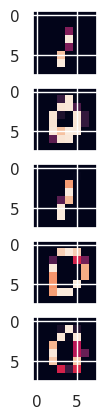

In [86]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(x_test[0].reshape(8,8)*255)
axarr[1].imshow(x_test[1].reshape(8,8)*255)
axarr[2].imshow(x_test[2].reshape(8,8)*255)
axarr[3].imshow(x_test[3].reshape(8,8)*255)
axarr[4].imshow(x_test[4].reshape(8,8)*255)

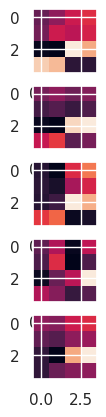

In [87]:

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(test_reduce[0].reshape(4,4)*255)
axarr[1].imshow(test_reduce[1].reshape(4,4)*255)
axarr[2].imshow(test_reduce[2].reshape(4,4)*255)
axarr[3].imshow(test_reduce[3].reshape(4,4)*255)
axarr[4].imshow(test_reduce[4].reshape(4,4)*255)

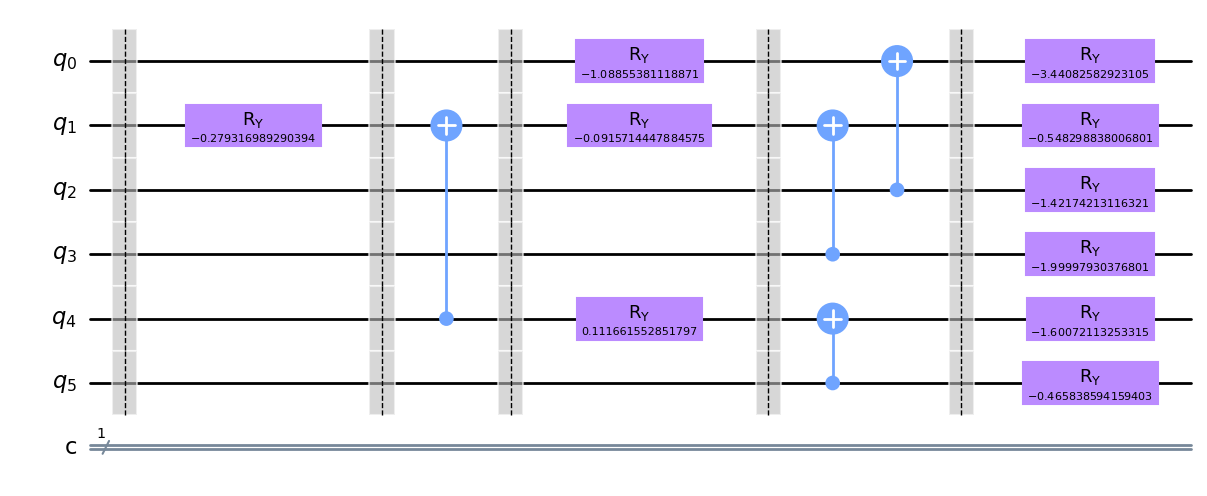

In [88]:
#We generate the inverse of the QVC
vqc(n,num_layers,params).inverse().draw(output = "mpl")

In [89]:
#Function to decode the test set values compressed
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with decode values
'''

def decoder_result_test(params):
    reduce = [] #List to save the decoded values
    #For each row in the test set reduced we will
    for i in range(len(test_reduce)):

        #Create a initial circuit with 6 qubits and a list of 48 zeros and the i row of the test reduced values
        circuit_init = input_data(6,np.concatenate((np.zeros(48), test_reduce[i]), axis=0))
        #Create the inverse VQC 
        circuit_vqc = vqc(n,num_layers,params).inverse()
        
        #Create a new circuit to combine the inicial circuit and the VQC
        circuit_full = QuantumCircuit(n,n)
        
        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector() #Get the results of the execution
        reduce.append(result) #Save the results
    return reduce
        
#Call the decoder_result_test function
decoder =decoder_result_test(params)

<ipython-input-90-826eccac2d46>:7: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  axarr[0].imshow(decoder[0].real.reshape(8,8)*255)
<ipython-input-90-826eccac2d46>:8: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  axarr[1].imshow(decoder[1].real.reshape(8,8)*255)
<ipython-input-90-826eccac2d46>:9: DeprecationWarning: The return type of saved statevectors has bee

<Figure size 640x480 with 0 Axes>

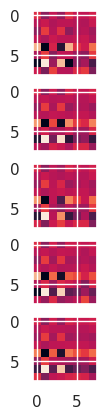

In [90]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5,1) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(decoder[0].real.reshape(8,8)*255)
axarr[1].imshow(decoder[1].real.reshape(8,8)*255)
axarr[2].imshow(decoder[2].real.reshape(8,8)*255)
axarr[3].imshow(decoder[3].real.reshape(8,8)*255)
axarr[4].imshow(decoder[4].real.reshape(8,8)*255)

In [91]:
#Function to decode the training set values compressed
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with decode values
'''
def decoder_result_train(params):
    reduce = [] #List to save the decoded values
    #For each row in the test set reduced we will
    for i in range(len(train_reduce)):
        #Create a initial circuit with 6 qubits and a list of 48 zeros and the i row of the test reduced values
        circuit_init = input_data(n,np.concatenate((np.zeros(48), train_reduce[i]), axis=0))
        #Create the inverse VQC 
        circuit_vqc = vqc(n,num_layers,params).inverse()

        #Create a new circuit to combine the inicial circuit and the VQC
        circuit_full = QuantumCircuit(n,n)
        
        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector() #Get the results of the execution
        reduce.append(result) #Save the results
    return reduce
     
#Call the decoder_result_train function    
decoder_train =decoder_result_train(params)

In [92]:
#Loading the MNIST set divided by a train set and a test set
(x_train_c, y_train_c), (x_test_c, y_test_c) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train_c, x_test_c = x_train_c[..., np.newaxis]/255.0, x_test_c[..., np.newaxis]/255.0

In [93]:
x_train_c, y_train_c = filter_01(x_train_c, y_train_c) #Filter the train set
x_test_c, y_test_c = filter_01(x_test_c, y_test_c) #Filter the test set

In [94]:
#resizing the images from 28x28 to 8x8 by the nearest method
x_train_c = tf.image.resize(x_train_c, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()
x_test_c = tf.image.resize(x_test_c, (8,8), method='nearest', preserve_aspect_ratio=True).numpy()

In [95]:
#Normalize the training set data
for i in range(len(x_train_c)):
    x_train_c[i] = Normalize(x_train_c[i])

#Normalize the test set data
for i in range(len(x_test)):
    x_test_c[i] = Normalize(x_test_c[i])

In [96]:
#Reshaping the train and test test to a 64x1 matriz
x_train_c = x_train_c.reshape(len(x_train_small), 64)
x_test_c = x_test_c.reshape(len(x_test_small), 64)

x_train_c.shape

(12665, 64)

In [97]:
#Function to compress the training set values
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with compress values
'''
def compress_result_train(params):
    reduce = [] #List to save the compress values
    #For each row in the training set we will
    for i in range(len(x_train_c)):
        circuit_init = input_data(n,x_train_c[i]) #Create a inicial circuit
        circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit

        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n,n-size_reduce)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full) #Known the length of the circuit
        #For each n - the the desired qubits to reduce we will
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i) #Measure the circuit in the position size_reduce+i
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=1024 )
        result = job.result().get_counts() #Get the results of the execution
        #Get the probabilities of each state
        probs = {k: np.sqrt(v / 1024) for k, v in result.items()}
        reduce.append(probs) #Save the probabilities
        
    return reduce

#Call the compress_result_train function with the parameters defined above
reduce_train_c = compress_result_train(params)

In [98]:
#Function to compress the test set values
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with compress values
'''
def compress_result_test(params):
    
    reduce = [] #List to save the compress values
    #For each row in the test set we will
    for i in range(len(x_test_c)):
        circuit_init = input_data(n,x_test_c[i]) #Create a inicial circuit
        circuit_vqc = vqc(n,num_layers,params) #Create a quantum variational circuit
    
        #Create a new circuit based on the size of the initial circuit and the desired qubits to reduce
        circuit_full = QuantumCircuit(n,n-size_reduce)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        len_cf = len(circuit_full) #Known the length of the circuit
        #For each n - the the desired qubits to reduce we will
        for i in range(n-size_reduce):
            circuit_full.measure(size_reduce+i, i) #Measure the circuit in the position size_reduce+i 
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('qasm_simulator'),shots=1024 )
        result = job.result().get_counts() #Get the results of the execution
        #Get the probabilities of each state
        probs = {k: np.sqrt(v / 1024) for k, v in result.items()}
        reduce.append(probs) #Save the probabilities
        
    return reduce

#Call the compress_result_test function with the parameters defined above
reduce_test_c = compress_result_test(params)

In [99]:
test_reduce = [] #List to save the new values of the image reduction
#for each value in the reduce_img list
for i in reduce_test_c:
    index_image = [] #List to save the reduction values
    #We now take in count we want a 4X4 image
    for j in range(16):
        bin_index = bin(j)[2:] #We take the binary value of j from the 2 position to the end
        while len(bin_index) <4: #While bin_index is less than 4
            bin_index = '0'+bin_index #We concatenate a 0 string at the beginnig
        try:   
            #We try to save the element of the row in the position bin_index
            index_image.append(i[bin_index])
        except:
            index_image.append(0) #If we can't, we only save a 0
            
    #We save the new imagen values in the test_recuce list
    test_reduce.append(np.array(index_image))

In [100]:
train_reduce = [] #List to save the new values of the image reduction
#for each value in the reduce_img list
for i in reduce_train_c:
    index_image = [] #List to save the reduction values
    #We now take in count we want a 4X4 image
    for j in range(16):
        bin_index = bin(j)[2:] #We take the binary value of j from the 2 position to the end
        while len(bin_index) <4: #While bin_index is less than 4
            bin_index = '0'+bin_index #We concatenate a 0 string at the beginnig
        try:  
            #We try to save the element of the row in the position bin_index
            index_image.append(i[bin_index])
        except:
            index_image.append(0) #If we can't, we only save a 0
        
    #We save the new imagen values in the train_recuce list
    train_reduce.append(np.array(index_image))

In [101]:
#Function to decode the training set values compressed
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with decode values
'''
def decoder_result_train_c(params):
    reduce = [] #List to save the decoded values
    #For each row in the test set reduced we will
    for i in range(len(train_reduce)):
        #Create a initial circuit with 6 qubits and a list of 48 zeros and the i row of the test reduced values
        circuit_init = input_data(n,np.concatenate((np.zeros(48), train_reduce[i]), axis=0))
        circuit_vqc = vqc(n,num_layers,params).inverse() #Create the inverse VQC 

        #Create a new circuit to combine the inicial circuit and the VQC
        circuit_full = QuantumCircuit(n,n)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') ) 
        result = job.result().get_statevector() #Get the results of the execution
        reduce.append(result) #Save the results
    return reduce

#Call the decoder_result_train function
decoder_train_c =decoder_result_train_c(params)
len(decoder_train_c) #Get the length of the decoder train list

12665

In [102]:
#Function to decode the test set values compressed
'''
Input: An array of parameters(vector of complex amplitudes)
Output: Array with decode values
'''
def decoder_result_test_c(params):
    reduce = [] #List to save the decoded values
    #For each row in the test set reduced we will
    for i in range(len(test_reduce)):

        #Create a initial circuit with 6 qubits and a list of 48 zeros and the i row of the test reduced values
        circuit_init = input_data(6,np.concatenate((np.zeros(48), test_reduce[i]), axis=0))
        #Create the inverse VQC 
        circuit_vqc = vqc(n,num_layers,params).inverse()

        #Create a new circuit to combine the inicial circuit and the VQC
        circuit_full = QuantumCircuit(n,n)

        #Combine the initial circuit, the quantum variatinal circuit
        circuit_full = circuit_full.compose(circuit_init,[i for i in range(n)])
        circuit_full = circuit_full.compose(circuit_vqc,[i for i in range(n)])
        #We will execute the full circuit in the qasm simulator
        job = execute( circuit_full, Aer.get_backend('statevector_simulator') )
        result = job.result().get_statevector() #Get the results of the execution
        reduce.append(result) #Save the results
    return reduce
        
#Call the decoder_result_test function
decoder_c =decoder_result_test_c(params)

In [103]:
import pandas as pd 



df = pd.DataFrame(train_reduce) #Dataframe for the training reduce set
df[16] = y_train #The class of each value is at the end of the dataframe
df.to_csv("train_1.csv",index=False) #Create the csv file with the results



df = pd.DataFrame(test_reduce) #Dataframe for the test reduce set
df[16] = y_test #The class of each value is at the end of the dataframe
df.to_csv("test_1.csv",index=False) #Create the csv file with the results

In [133]:
# Scikit Imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [105]:
sample_train = [] #List from the sample train
label_train = [] #List from the label train
with open('train_1.csv', newline='') as csvfile: #Open the csv file that we before create
    reader = csv.reader(csvfile, delimiter=',') #Reading the csv file and get the values by commas
    next(reader, None) #We ignore the header
    for row in reader: #We go for each row of the file
        sample_train.append(row[0:-1]) #The values of the samples are all except the last cell
        label_train.append(row[-1]) #The class of that row is the last cell
sample_train = np.array(sample_train).astype(np.float) #Convert the sample train to a numpy float array
label_train = np.array(label_train).astype(np.float) #Convert the label train to a numpy float array
sample_train.shape, label_train.shape #Show the shape of the arrays

<ipython-input-105-062e607c369d>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_train = np.array(sample_train).astype(np.float) #Convert the sample train to a numpy float array
<ipython-input-105-062e607c369d>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_train = np.array(label_train).astype(np.float) #Convert the label

((12665, 16), (12665,))

In [106]:
sample_test = [] #List from the sample test
label_test = [] #List from the label test
with open('test_1.csv', newline='') as csvfile: #Open the csv file that we before create
    reader = csv.reader(csvfile, delimiter=',') #Reading the csv file and get the values by commas
    next(reader, None) #We ignore the header
    for row in reader: #We go for each row of the file
        sample_test.append(row[0:-1]) #The values of the samples are all except the last cell
        label_test.append(row[-1]) #The class of that row is the last cell
sample_test = np.array(sample_test).astype(np.float) #Convert the sample test to a numpy float array
label_test = np.array(label_test).astype(np.float) #Convert the label test to a numpy float array
sample_test.shape, label_test.shape #Show the shape of the arrays

<ipython-input-106-216e1b077fa8>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_test = np.array(sample_test).astype(np.float) #Convert the sample test to a numpy float array
<ipython-input-106-216e1b077fa8>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_test = np.array(label_test).astype(np.float) #Convert the label test

((2115, 16), (2115,))

In [107]:
sample_train = sample_train.reshape(len(sample_train), 16) #Reshape the sample train to a 16X1 array
sample_test = sample_test.reshape(len(sample_test), 16) #Reshape the sample test to a 16X1 array

In [108]:
train_size = 700 #Number of samples of the training sample
sample_train = sample_train[:train_size] #Reduce the sample train
label_train = label_train[:train_size] #Reduce the label train

test_size = 300 #Number of samples of the test sample
sample_test = sample_test[:test_size] #Reduce the sample test
label_test = label_test[:test_size] #Reduce the label test

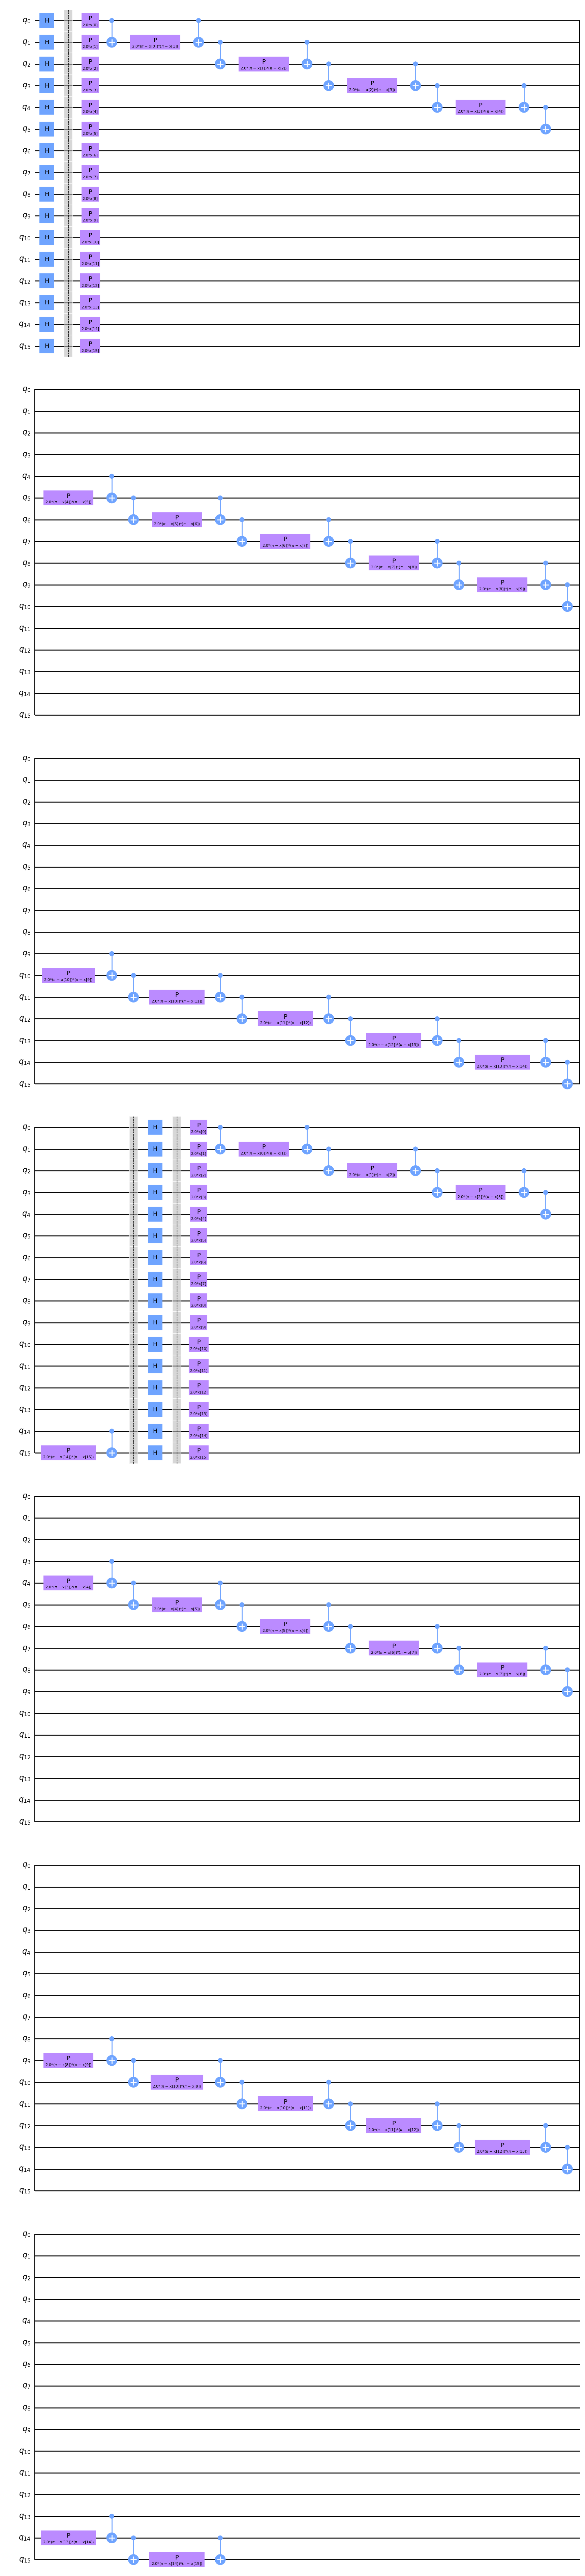

In [134]:
#map the classical vector to a quantum state with the ZZFeatureMap, 16 qubits, 2 repetiton and a linear entanglement
zz_map = ZZFeatureMap(feature_dimension=16, reps=2, entanglement='linear', insert_barriers=True)
#Create the quantum kernel with the ZZFeatureMap
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
#Show the ZZFeatureMap with 16 qubits
zz_map.decompose().draw(output="mpl")

In [110]:
#We create the matrix_train with the sample train values
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
#We create the matrix test with the sample test and sample train values
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

In [111]:
#We use a SVC with a precomputed kerner
zzpc_svc = SVC(kernel='precomputed') 
#We fit the model with the train matrix and the label train
zzpc_svc.fit(matrix_train, label_train)
#We calculate the score of the model with the matrix test and label test
zzpc_score = zzpc_svc.score(matrix_test, label_test)

#We show the score value
print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.9266666666666666


In [112]:
#Make a prediction using the test matrix
predictions = zzpc_svc.predict(matrix_test)

In [113]:
#We need to see how many prediction go wrong
for prediction,label in zip(predictions,label_test):
    if(prediction != label): #If the prediction is different from the class
        print(prediction, label)

1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
1.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
1.0 0.0
1.0 0.0


In [120]:
class_0, class_1 = [], []
for i in range(len(label_test)):
    if (predictions[i] == label_test[i]):
        if (label_test[i] == 0):
            class_0.append(sample_test[i])
        else:
            class_1.append(sample_test[i])

print(len(class_0))
print(len(class_1))

105
173


In [131]:
import random

len0 = len(class_0)
len1 = len(class_1)

idx0, idx1 = random.randint(0, len0-1), random.randint(0, len0-1)
print(idx0, idx1)

print("Fidelity of two images from the same class: ", compute_fidelity(4, input_data(4, class_0[idx0]), input_data(4, class_0[idx1])))

idx0, idx1 = random.randint(0, len1-1), random.randint(0, len1-1)
print(idx0, idx1)

print("Fidelity of two images from the same class: ", compute_fidelity(4, input_data(4, class_1[idx0]), input_data(4, class_1[idx1])))

idx0, idx1 = random.randint(0, len0-1), random.randint(0, len1-1)
print(idx0, idx1)

print("Fidelity of two images from two different classes: ", compute_fidelity(4, input_data(4, class_0[idx0]), input_data(4, class_1[idx1])))


67 10
Fidelity of two images from the same class:  0.826171875
107 150
Fidelity of two images from the same class:  0.984375
73 165
Fidelity of two images from two different classes:  0.5703125


### Conclusion

We can see that the fidelity of two images from the same class is maximized while the fidelity of two images from different classes is minimized. This indicates that the classifier is working correctly. Additionally, the classifier was able to achieve an accuracy score of approximately 92.6% in the test set.